In [46]:
import pandas as pd
import numpy as np
import pathlib as pl


from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests

from scipy.stats import mannwhitneyu, fisher_exact, pearsonr, kruskal

In [47]:
import sys
import os
sys.path.append("../../FinalCode/")
import download.download as dwnl
import utils.plotting as plting
import adVMP.adVMP_discovery as discov
import adVMP.adVMP_plots as advmpplt

In [48]:
# For figures
colors = sns.color_palette("muted")
palette = {"Normal": colors[0], "NADJ-A": colors[3], "NADJ-C": colors[2], "Adenoma": colors[3], "SSL": colors[4], "Cancer": colors[5]}
fig_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/ArticleFigures/unit")

In [49]:
base_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC/")
base_dir4 = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC4/")

data_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/")

bad_probes = pd.read_csv(data_dir / "auxiliary" / "sketchy_probe_list_epic.csv",index_col=0).values.ravel()
sample_origin_path = pl.Path(data_dir / "clinical" / "sample_origin_wbatch.csv")

clinical_path = pl.Path(data_dir / "clinical" / "cleaned_clinical_reduced_diet.csv")
target_path = pl.Path(data_dir / "clinical" / "targets.csv")

In [50]:
EPIC2_b, EPIC2_clin, EPIC2_samples, EPIC2_phenotypes, EPIC3_b, EPIC3_clin, EPIC3_samples, EPIC3_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir, clinical_path=clinical_path, target_path=target_path,
                  bad_probes=bad_probes, EPIC4=False) 

30it [00:04,  7.41it/s]


In [51]:
EPIC4_b, EPIC4_clin, EPIC4_samples, EPIC4_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir4, clinical_path=clinical_path, target_path=target_path, 
                  bad_probes=bad_probes, EPIC4=True) 

18it [00:03,  5.71it/s]


# Load CpGs

In [52]:
union_cpgs = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP/union_cpgs.csv", index_col=0).values.ravel()

# Map Roadmap Epigenomics to EPIC array

In [9]:
roadmap = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/NIH_Epigenomics_Roadmap/E075_15_coreMarks_dense.bed.gz",sep="\t",skiprows=1,header=None)

roadmap = roadmap.iloc[:,:4]

roadmap.columns = ["chrom","start","end","state"]

In [10]:
epic_manifest = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/illumina_manifests/GPL21145_MethylationEPIC_15073387_v-1-0.csv.gz",skiprows=7,index_col=0)

/var/folders/y0/0jmz5bl96kb57fmb09fl6fdw0000gn/T/ipykernel_4289/2459526395.py:1: DtypeWarning: Columns (0,2,4,5,6,7,8,9,11,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,34,36,38,39,40,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  epic_manifest = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/illumina_manifests/GPL21145_MethylationEPIC_15073387_v-1-0.csv.gz",skiprows=7,index_col=0)


In [14]:
probes = epic_manifest[['CHR', 'MAPINFO']].dropna()
probes = probes.loc[~probes.index.duplicated()]

probes_pc = {}
for chrom in sorted(probes.CHR.unique()):
    probes_pc[chrom] = probes[probes["CHR"]==chrom].sort_values(by="MAPINFO")

mapping = {}
for i in tqdm(probes_pc):
    chromosome = f'chr{i}'
    if chromosome=="chr0":
        continue
    print(chromosome)
    roadmap_chrom = roadmap[roadmap["chrom"]==chromosome]
    for cg in tqdm(probes_pc[i].index):
        pos = probes_pc[i].loc[cg,"MAPINFO"]
        found = roadmap_chrom[(roadmap_chrom["start"]<=pos) & (roadmap_chrom["end"]>pos)]
        if found.shape[0]==0:
            print(f"No mapping for {cg}")
            mapping[cg] = ["None"]
        else:
            mapping[cg] = found["state"].values

mapping_dict = pd.DataFrame.from_dict(mapping).T

mapping_dict.columns = ["State"]

mapping_dict = pd.concat([probes,mapping_dict],axis=1)

  0%|          | 0/24 [00:00<?, ?it/s]

chr1


  0%|          | 0/82193 [00:00<?, ?it/s]

chr10


  0%|          | 0/42221 [00:00<?, ?it/s]

chr11


  0%|          | 0/49025 [00:00<?, ?it/s]

chr12


  0%|          | 0/44738 [00:00<?, ?it/s]

chr13


  0%|          | 0/21094 [00:00<?, ?it/s]

chr14


  0%|          | 0/29627 [00:00<?, ?it/s]

chr15


  0%|          | 0/28799 [00:00<?, ?it/s]

chr16


  0%|          | 0/38060 [00:00<?, ?it/s]

chr17


  0%|          | 0/44535 [00:00<?, ?it/s]

chr18


  0%|          | 0/14928 [00:00<?, ?it/s]

chr19


  0%|          | 0/38676 [00:00<?, ?it/s]

chr2


  0%|          | 0/64940 [00:00<?, ?it/s]

chr20


  0%|          | 0/23020 [00:00<?, ?it/s]

chr21


  0%|          | 0/10323 [00:00<?, ?it/s]

chr22


  0%|          | 0/18405 [00:00<?, ?it/s]

chr3


  0%|          | 0/48963 [00:00<?, ?it/s]

chr4


  0%|          | 0/36843 [00:00<?, ?it/s]

chr5


  0%|          | 0/44805 [00:00<?, ?it/s]

chr6


  0%|          | 0/54527 [00:00<?, ?it/s]

chr7


  0%|          | 0/47680 [00:00<?, ?it/s]

chr8


  0%|          | 0/38540 [00:00<?, ?it/s]

chr9


  0%|          | 0/26224 [00:00<?, ?it/s]

chrX


  0%|          | 0/19140 [00:00<?, ?it/s]

chrY


  0%|          | 0/561 [00:00<?, ?it/s]

In [15]:
mapping_dict = mapping_dict.dropna()

In [16]:
mapping_dict.to_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/NIH_Epigenomics_Roadmap/EPIC_to_state_mapping.csv")

# Get enrichment

In [53]:
mapping_dict = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/NIH_Epigenomics_Roadmap/EPIC_to_state_mapping.csv",index_col=0)

In [54]:
meaningful_groups = {"1_TssA": "Active promoter", "2_TssAFlnk": "Active promoter", "3_TxFlnk": "Active promoter", 
                     "4_Tx": "Transcription (body)", "5_TxWk": "Transcription (body)", 
                     "6_EnhG": "Enhancer", "7_Enh": "Enhancer", "8_ZNF/Rpts": "ZNF/Repeats", 
                     "10_TssBiv": "Bivalent promoter", "11_BivFlnk": "Bivalent promoter", 
                     "12_EnhBiv": "Bivalent enhancer", "13_ReprPC": "Repressed polycomb", 
                     "14_ReprPCWk": "Repressed polycomb", "15_Quies": "Quiescent"}

In [55]:
mapping_dict["Red_State"] = mapping_dict["State"].replace(meaningful_groups)

In [56]:
df = mapping_dict.loc[union_cpgs].Red_State.value_counts()
dict_states = df.to_dict()

In [57]:
df

Active promoter         125
Bivalent promoter        57
Transcription (body)     29
Quiescent                23
Repressed polycomb       19
Bivalent enhancer         8
Enhancer                  6
ZNF/Repeats               1
Name: Red_State, dtype: int64

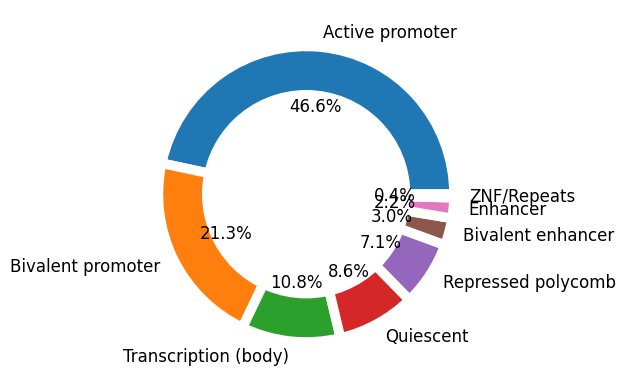

In [21]:
# create data
names = list(dict_states.keys())
size = list(dict_states.values())
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%"

# Custom wedges
plt.pie(size, labels=names, 
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, autopct=lambda pct: func(pct, size), 
        textprops=dict(color="black", size=12))
p = plt.gcf()
p.gca().add_artist(my_circle)
p.savefig(fig_dir / "donut_plot_enrichment_roadmap.svg", bbox_inches="tight")

In [66]:
cl_bright = sns.color_palette()
pl = {"Active promoter": cl_bright[0], "Bivalent promoter": cl_bright[1], 
      "Transcription (body)": cl_bright[2], "Quiescent": cl_bright[3], 
      "Repressed polycomb": cl_bright[4], "Bivalent enhancer": cl_bright[5], 
      "Enhancer": cl_bright[6], "ZNF/Repeats": cl_bright[7]}

In [59]:
background_cpgs = EPIC4_b.columns.intersection(EPIC2_b.columns).to_numpy()

In [60]:
def get_fisher_enrichment(mapping_dict: pd.DataFrame, 
                          background: np.ndarray, 
                          union_cpgs: np.ndarray, state_col: str="State") -> pd.DataFrame:
    
    common_probes = mapping_dict.index.intersection(background)
    mapping_background = mapping_dict.loc[common_probes]

    vc_uc = mapping_background.loc[mapping_background.index.isin(union_cpgs)][state_col].value_counts()

    vc_nuc = mapping_background.loc[~mapping_background.index.isin(union_cpgs)][state_col].value_counts()

    fisher_enrichment = {}
    for state in vc_uc.index:
        a = vc_uc.loc[state]
        b = vc_nuc.loc[state]
        c = vc_uc.sum() - a
        d = vc_nuc.sum() - b
        OR, p = fisher_exact(np.array([[a,c],[b,d]]))
        fisher_enrichment[state] = [OR,p]

    fisher_enrichment = pd.DataFrame.from_dict(fisher_enrichment).T
    fisher_enrichment.columns = ["OR","p"]

    q = multipletests(fisher_enrichment["p"],method="fdr_bh")[1]

    fisher_enrichment["q"] = q
    fisher_enrichment["log2(OR)"] = fisher_enrichment["OR"].apply(np.log2)
    
    return fisher_enrichment

In [61]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [62]:
fisher_enrichment = get_fisher_enrichment(mapping_dict=mapping_dict, 
                                          background=background_cpgs, 
                                          union_cpgs=union_cpgs, state_col="Red_State")
fisher_enrichment = fisher_enrichment.sort_values(by="log2(OR)",ascending=False)

In [63]:
annotations = fisher_enrichment['q'].apply(convert_pvalue_to_asterisks).ravel()

/var/folders/y0/0jmz5bl96kb57fmb09fl6fdw0000gn/T/ipykernel_14762/644469712.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)


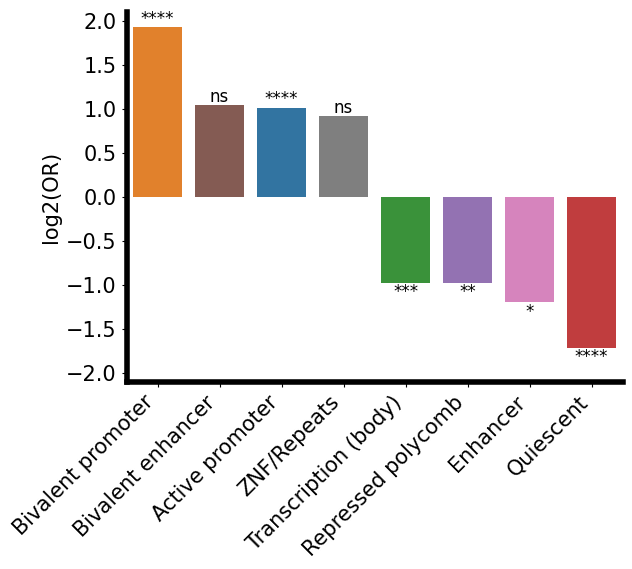

In [67]:
fig, ax = plt.subplots(1,1)
sns.barplot(data=fisher_enrichment.sort_values(by="log2(OR)",ascending=False).reset_index(),
            palette = pl, x="index",y="log2(OR)",ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["bottom", "left"]].set_linewidth(4)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,horizontalalignment="right",fontsize=15)
ax.set_ylim(bottom=-2.1, top=2.1)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)
ax.set_xlabel("")
ax.set_ylabel("log2(OR)",fontsize=15)


y_positions = fisher_enrichment["log2(OR)"]
y_positions= y_positions.apply(lambda x: x+0.1 if x>0 else x-0.1)
y_positions = y_positions.ravel()
for idx, pval in enumerate(annotations):
    plt.text(x=idx, y=y_positions[idx], s=pval, ha="center", va="center", fontsize=12)
fig.savefig(fig_dir / "adVMP_roadmap_enrichment.svg", bbox_inches="tight")

# Follow up

In [35]:
epic41 = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/follow_up/follow-up/EPIC4_follow_up.csv",index_col=0)

In [36]:
epic42 = pd.read_csv("/Users/josephineyates/Documents/CRC_polyp/FinalData/follow_up/follow-up/EPIC4_follow_up.csv",sep=";",index_col=0)

In [37]:
epic42 = epic42.drop(["Unnamed: 1","Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)

In [38]:
epic42

,SWEPIC Nr,Sample ID,Vitodata Nr,Initials,FU swepic,FU any,Polyps,"Nr, Size, Local",Histo,Special
",Hit fraction,Ad,patient_id,specimen_type,batch",,,,,,,,,,
"1064801,0.0,0,501,cecum,EPIC4",501.0,10648.0,10836.0,FM,NaN,n,NaN,NaN,NaN,NaN
"1067101,0.0037313432835820895,0,580,cecum,EPIC4",580.0,10671.0,10936.0,SR,NaN,11 21,y,2x4mm A,SSL u HP,NaN
"1136501,0.0037313432835820895,0,1554,cecum,EPIC4",1554.0,11365.0,13233.0,MP,NaN,n,NaN,NaN,NaN,NaN
"1100201,0.007462686567164179,0,866,cecum,EPIC4",866.0,11002.0,11717.0,SR,NaN,01 22,NaN,NaN,NaN,NaN
"1178601,0.007462686567164179,0,1622,cecum,EPIC4",1622.0,11786.0,13168.0,WS,NaN,n,NaN,NaN,NaN,NaN
"1072401,0.007462686567164179,0,662,cecum,EPIC4",662.0,10724.0,4517.0,KP,NaN,11 20,y,"1x5mm A, 1x10mm D",TA LGD,NaN
"1064201,0.007462686567164179,0,473,cecum,EPIC4",473.0,10642.0,10799.0,RE,NaN,01 21,n,NaN,NaN,NaN
"1082901,0.007462686567164179,0,680,cecum,EPIC4",680.0,10829.0,11337.0,MA,y,08 20,n,NaN,NaN,NaN
"1105801,0.007462686567164179,0,845,cecum,EPIC4",845.0,11058.0,1317.0,GE,NaN,11 20,y,1x4mm T,TA LGD,NaN


In [27]:
epic42.index = epic4.index

In [32]:
epic4 =pd.concat([epic4.iloc[:,:4],epic42],axis=1)

In [34]:
epic4

,Hit fraction,Ad,patient_id,specimen_type,SWEPIC Nr,Sample ID,Vitodata Nr,Initials,FU swepic,FU any,Polyps,"Nr, Size, Local",Histo,Special
1064801,0.0,0.0,501.0,cecum,501.0,10648.0,10836.0,FM,NaN,n,NaN,NaN,NaN,NaN
1067101,0.0037313432835820895,0.0,580.0,cecum,580.0,10671.0,10936.0,SR,NaN,11 21,y,2x4mm A,SSL u HP,NaN
1136501,0.0037313432835820895,0.0,1554.0,cecum,1554.0,11365.0,13233.0,MP,NaN,n,NaN,NaN,NaN,NaN
1100201,0.007462686567164179,0.0,866.0,cecum,866.0,11002.0,11717.0,SR,NaN,01 22,NaN,NaN,NaN,NaN
1178601,0.007462686567164179,0.0,1622.0,cecum,1622.0,11786.0,13168.0,WS,NaN,n,NaN,NaN,NaN,NaN
1072401,0.007462686567164179,0.0,662.0,cecum,662.0,10724.0,4517.0,KP,NaN,11 20,y,"1x5mm A, 1x10mm D",TA LGD,NaN
1064201,0.007462686567164179,0.0,473.0,cecum,473.0,10642.0,10799.0,RE,NaN,01 21,n,NaN,NaN,NaN
1082901,0.007462686567164179,0.0,680.0,cecum,680.0,10829.0,11337.0,MA,y,08 20,n,NaN,NaN,NaN
1105801,0.007462686567164179,0.0,845.0,cecum,845.0,11058.0,1317.0,GE,NaN,11 20,y,1x4mm T,TA LGD,NaN
1151501,0.007462686567164179,0.0,1485.0,cecum,1485.0,11515.0,12899.0,PGC,NaN,n,NaN,NaN,NaN,NaN


In [39]:
from scipy.stats import fisher_exact

In [41]:
fisher_exact(np.array([[3,2],[4,0]]))

(0.0, 0.4444444444444444)

In [42]:
fisher_exact(np.array([[2,3],[3,0]]))

(0.0, 0.19642857142857137)

In [43]:
fisher_exact(np.array([[2,2],[2,3]]))

(1.5, 1.0)

In [44]:
fisher_exact(np.array([[7,7],[9,3]]))

(0.3333333333333333, 0.24751648943330187)

In [45]:
fisher_exact(np.array([[5,5],[7,0]]))

(0.0, 0.04411764705882353)